# IMDB Movie Review Sentiment Analysis

## Import Modules


In [76]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare Datasets


In [2]:
train_ds = load_dataset("stanfordnlp/imdb", split="train")
test_ds = load_dataset("stanfordnlp/imdb", split="test")

train_ds, test_ds

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [3]:
train_ds[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

## Check for Class balance


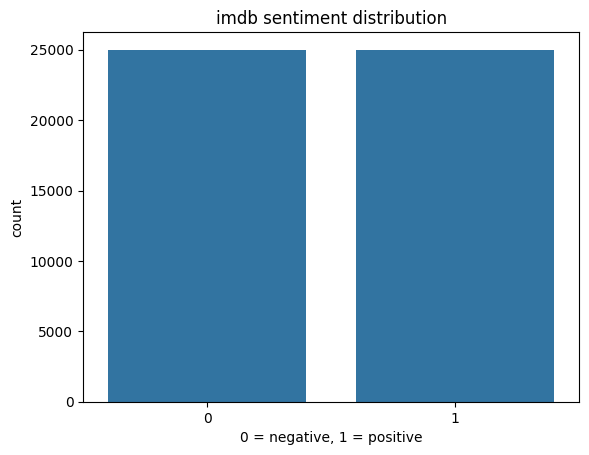

In [83]:
train_df = pd.DataFrame(train_ds)
test_df = pd.DataFrame(test_ds)

df = pd.concat([train_df, test_df], ignore_index=True)

sns.countplot(data=df, x="label")
plt.title("imdb sentiment distribution")
plt.xlabel("0 = negative, 1 = positive")
plt.ylabel("count")
plt.show()

In [91]:
classes_label = df["label"].unique()
print(classes_label)

[0 1]


In [93]:
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes_label,
    y=train_ds['label']
)
weights = torch.tensor(weights, dtype=torch.float)
weights

tensor([1., 1.])

## Pretrained Model Selection


In [ ]:
model_name = "distilbert-base-uncased" # distilbert = lightweight version of the original bert

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2, # negative and positive
)

model.to(device)

c:\Users\Nizwa\miniconda3\envs\ai\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nizwa\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1326.64it/s, Materializing param=distilbert.transformer.

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [101]:
# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Trainable parameters only
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 66,955,010
Trainable parameters: 66,955,010


## Tokenize Dataset


In [33]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized_train = train_ds.map(tokenize, batched=True, batch_size=1024)
tokenized_test = test_ds.map(tokenize, batched=True, batch_size=1024)

Map: 100%|██████████| 25000/25000 [00:03<00:00, 6792.62 examples/s]


In [34]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})

In [37]:
tokenized_train[0]['attention_mask'], tokenized_train[0]['token_type_ids']

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [36]:
# remove the raw text column, we dont want a string
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

In [38]:
tokenized_train[0]['input_ids'], tokenized_train[0]['label']

(tensor([  101,  1045, 12524,  1045,  2572,  8025,  1011,  3756,  2013,  2026,
          2678,  3573,  2138,  1997,  2035,  1996,  6704,  2008,  5129,  2009,
          2043,  2009,  2001,  2034,  2207,  1999,  3476,  1012,  1045,  2036,
          2657,  2008,  2012,  2034,  2009,  2001,  8243,  2011,  1057,  1012,
          1055,  1012,  8205,  2065,  2009,  2412,  2699,  2000,  4607,  2023,
          2406,  1010,  3568,  2108,  1037,  5470,  1997,  3152,  2641,  1000,
          6801,  1000,  1045,  2428,  2018,  2000,  2156,  2023,  2005,  2870,
          1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,  1028,  1996,
          5436,  2003,  8857,  2105,  1037,  2402,  4467,  3689,  3076,  2315,
         14229,  2040,  4122,  2000,  4553,  2673,  2016,  2064,  2055,  2166,
          1012,  1999,  3327,  2016,  4122,  2000,  3579,  2014,  3086,  2015,
          2000,  2437,  2070,  4066,  1997,  4516,  2006,  2054,  1996,  2779,
         25430, 14728,  2245,  2055,  3056,  2576,  

## Model Training (Fine tuning)


In [39]:
def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")

    return {"accuracy": acc, "f1": f1}

In [ ]:
LR = 2e-5
BATCH_SIZE = 16
NUM_EPOCH = 3
output_path = "./results/imdb-sentiment"

training_args = TrainingArguments(
    output_dir=output_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCH,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [47]:
data_collator = DataCollatorWithPadding(tokenizer)

### Unbalanced Class Trainer


In [99]:
# DISCLAIMER: i have not test this trainer class yet.

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss
    

wtrainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

### Balanced Class Trainer


In [48]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

### Train then save the weights

In [49]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.124314,0.423829,0.899800,0.899742
2,0.101404,0.415768,0.908080,0.908074
3,0.059243,0.475428,0.908040,0.908034


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=4689, training_loss=0.0897598030674455, metrics={'train_runtime': 737.151, 'train_samples_per_second': 101.743, 'train_steps_per_second': 6.361, 'total_flos': 4967527449600000.0, 'train_loss': 0.0897598030674455, 'epoch': 3.0})

In [ ]:
trainer.save_model(output_path)
tokenizer.save_pretrained(output_path)

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


('./results\\tokenizer_config.json', './results\\tokenizer.json')

## Evaluate Model


In [ ]:
output_path = "./results/imdb-sentiment"

tokenizer = AutoTokenizer.from_pretrained(output_path)
model = AutoModelForSequenceClassification.from_pretrained(output_path)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Loading weights: 100%|██████████| 104/104 [00:00<00:00, 961.50it/s, Materializing param=pre_classifier.weight]                                  


In [59]:
eval_results = trainer.evaluate(eval_dataset=tokenized_test)
eval_results

{'eval_loss': 0.4157676100730896,
 'eval_model_preparation_time': 0.001,
 'eval_accuracy': 0.90808,
 'eval_f1': 0.9080741167434715,
 'eval_runtime': 62.8581,
 'eval_samples_per_second': 397.721,
 'eval_steps_per_second': 24.866}

In [60]:
pred = trainer.predict(tokenized_test)
pred.metrics

{'test_loss': 0.4157676100730896,
 'test_model_preparation_time': 0.001,
 'test_accuracy': 0.90808,
 'test_f1': 0.9080741167434715,
 'test_runtime': 64.0737,
 'test_samples_per_second': 390.176,
 'test_steps_per_second': 24.394}

In [63]:
pred.predictions, pred.label_ids

(array([[ 3.1628127 , -3.436293  ],
        [ 3.1656551 , -3.3231685 ],
        [ 3.0090222 , -3.3332026 ],
        ...,
        [-0.15786405,  0.37320307],
        [-1.3740416 ,  1.2742677 ],
        [-2.4534705 ,  2.4050052 ]], shape=(25000, 2), dtype=float32),
 array([0, 0, 0, ..., 1, 1, 1], shape=(25000,)))

In [ ]:
# since predicitions output a logits (not proba), just apply argmax
pred_labels = np.argmax(pred.predictions, axis=1)
pred_labels

array([0, 0, 0, ..., 1, 1, 1], shape=(25000,))

In [82]:
y_df = pd.DataFrame({
    "predicted": pred_labels,
    "true": pred.label_ids,
})
y_df.head()

,predicted,true
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0


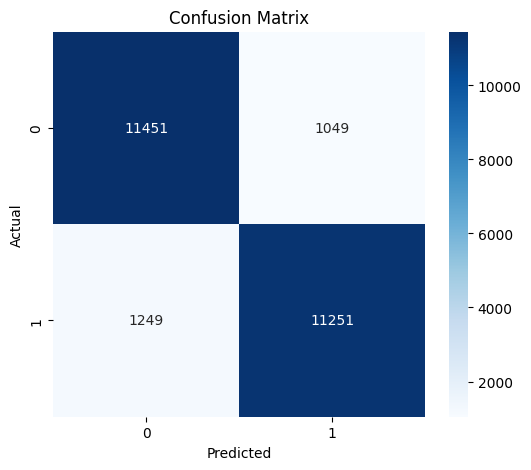

In [74]:
cm = confusion_matrix(pred.label_ids, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [75]:
report = classification_report(pred.label_ids, pred_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.head()

,precision,recall,f1-score,support
0,0.901654,0.91608,0.908810,12500.00000
1,0.914715,0.90008,0.907339,12500.00000
accuracy,0.908080,0.90808,0.908080,0.90808
macro avg,0.908184,0.90808,0.908074,25000.00000
weighted avg,0.908184,0.90808,0.908074,25000.00000


## Raw Inference (Pytorch)


In [ ]:
texts = [
    "I absolutely loved this movie!",
    "This product is terrible and I regret buying it."
]

inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

# move to model device
inputs = {k: v.to(model.device) for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)

print(predictions)

tensor([1, 0], device='cuda:0')


In [100]:
print("hooray")

hooray
